# Easy

The Easy problems use the samples from the posterior distribution for the globe tossing example. This code will give you a specific set of samples, so that you can check your answers exactly.

In [172]:
# imports
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import arviz as az

In [173]:
@tf.function
def grid_approx(grid_size, num_draws, num_successes, prior=tf.ones([1000, 1])):
    # define grid
    p_grid = tf.linspace(start=0., stop=1., num=grid_size)
    p_grid = tf.expand_dims(p_grid, 1)
    # compute likelihood at each value in grid
    likelihood = tfd.Binomial(num_draws, probs=p_grid).prob(num_successes)
    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior
    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / tf.math.reduce_sum(unstd_posterior)
    return p_grid, posterior

@tf.function
def generate_posterior_samples(num_samples, posterior, grid_size):
    samples = tfd.Categorical(probs=tf.reshape(posterior, [grid_size])).sample(num_samples)
    posterior_samples = samples / (grid_size - 1)
    return posterior_samples

In [174]:
tf.random.set_seed(123)
grid_size = 1000
num_draws = 9
num_successes = 6
num_samples = 1e5
(p_grid, posterior) = grid_approx(grid_size, num_draws, num_successes)
samples = generate_posterior_samples(num_samples, posterior, grid_size)

3E1. How much posterior probability lies below p = 0.2?

In [175]:
# for posterior
# numpy
np.sum(posterior[p_grid < 0.2])

0.00085609517

In [176]:
# for posterior
# tfp
tf.reduce_sum(posterior[tf.math.less(p_grid, 0.2)])

<tf.Tensor: shape=(), dtype=float32, numpy=0.00085609517>

In [177]:
# for posterior samples
# numpy
np.sum(samples < 0.2) / np.size(samples)

0.00074

In [178]:
# for posterior samples
# tfp
cond = tf.cast(tf.math.less(samples, 0.2), dtype=tf.int32)
tf.reduce_sum(cond) / tf.size(samples)

<tf.Tensor: shape=(), dtype=float64, numpy=0.00074>

3E2. How much posterior probability lies above p = 0.8?

In [179]:
# posterior
tf.reduce_sum(posterior[tf.math.greater(p_grid, 0.8)])

<tf.Tensor: shape=(), dtype=float32, numpy=0.12034495>

In [180]:
# posterior samples
cond = tf.cast(tf.math.greater(samples, 0.8), dtype=tf.int32)
tf.reduce_sum(cond) / tf.size(samples)

<tf.Tensor: shape=(), dtype=float64, numpy=0.12145>

3E3. How much posterior probability lies between p = 0.2 and p = 0.8?

In [181]:
# posterior
cond = tf.logical_and(tf.math.greater(p_grid, 0.2), tf.math.less(p_grid, 0.8))
tf.reduce_sum(posterior[cond])

<tf.Tensor: shape=(), dtype=float32, numpy=0.878799>

In [182]:
# posterior samples
cond = tf.cast(tf.logical_and(tf.math.greater(samples, 0.2), tf.math.less(samples, 0.8)), dtype=tf.int32)
tf.reduce_sum(cond) / tf.size(samples)

<tf.Tensor: shape=(), dtype=float64, numpy=0.87781>

3E4. 20% of the posterior probability lies below which value of p?

In [183]:
quants = tfp.stats.quantiles(samples, 5)
print(quants[1].numpy())

0.5165165165165165


3E5. 20% of the posterior probability lies above which value of p?

In [184]:
quants = tfp.stats.quantiles(samples, 5)
print(quants[4].numpy())

0.7607607607607607


3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [185]:
# note that az.hdi seems to differ slightly from McElreath's hpdi
az.hdi(samples.numpy(), hdi_prob=0.66)

array([0.52352352, 0.7957958 ])

3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probabil-
ity both below and above the interval?

In [186]:
quants = tfp.stats.quantiles(samples, 100)
print("66% of posterior probability lies between p={:1.2f} and p={:1.2f}".format(quants[17].numpy(),quants[83].numpy()))

66% of posterior probability lies between p=0.50 and p=0.77


# Medium

3M1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

In [187]:
grid_size = 1000
num_draws = 15
num_successes = 8
(p_grid, posterior) = grid_approx(grid_size, num_draws, num_successes)

3M2. Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p.

In [188]:
num_samples = 1e5
samples = generate_posterior_samples(num_samples, posterior, grid_size)
az.hdi(samples.numpy(), hdi_prob=0.90)

array([0.33433433, 0.72172172])

3M3. Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing
8 water in 15 tosses?

In [189]:
@tf.function
def posterior_prediction(num_draws, obs, posterior_samples):
    w = tfd.Binomial(num_draws, probs=posterior_samples).sample(1)
    return tf.reduce_sum(tf.cast(w[0,:] == obs, dtype=tf.int32)) / tf.size(w)


In [190]:
posterior_prediction(15, 8, samples)

<tf.Tensor: shape=(), dtype=float64, numpy=0.14675000000000002>

3M4. Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

In [191]:
grid_size = 1000
num_draws = 9
num_successes = 6
posterior_prediction(num_draws, num_successes, samples)

<tf.Tensor: shape=(), dtype=float64, numpy=0.17606000000000002>

In [192]:
# check answer by using posterior and grid approximation
@tf.function
def predict_grid_approx(grid_size, num_draws, num_successes, prior):
    # define grid
    p_grid = tf.linspace(start=0., stop=1., num=grid_size)
    p_grid = tf.expand_dims(p_grid, 1)
    # compute likelihood at each value in grid
    likelihood = tfd.Binomial(num_draws, probs=p_grid).prob(num_successes)
    return tf.reduce_sum(likelihood * prior)


In [193]:
predict_grid_approx(1000, 9, 6, posterior)

<tf.Tensor: shape=(), dtype=float32, numpy=0.17638987>

3M5. Start over at 3M1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5.
This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each
problem above and compare the inferences. What difference does the better prior make? If it helps,
compare inferences (using both priors) to the true value p = 0.7.

In [194]:
prior = tf.constant(np.expand_dims(np.array([0 if i < 0.5 else 1 for i in p_grid], dtype=np.float32), 1))

In [195]:
#3m1 with new prior
grid_size = 1000
num_draws = 15
num_successes = 8
(p_grid, posterior) = grid_approx(grid_size, num_draws, num_successes, prior)

In [196]:
#3m2 with new prior
num_samples = 1e5
samples = generate_posterior_samples(num_samples, posterior, grid_size)
az.hdi(samples.numpy(), hdi_prob=0.90)

array([0.5005005 , 0.71171171])

In [197]:
#3m3 with new prior
posterior_prediction(15, 8, samples)

<tf.Tensor: shape=(), dtype=float64, numpy=0.15780000000000002>

In [198]:
#3m4 with new prior
grid_size = 1000
num_draws = 9
num_successes = 6
posterior_prediction(num_draws, num_successes, samples)

<tf.Tensor: shape=(), dtype=float64, numpy=0.23153>

3M6. Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you
want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means
the distance between the upper and lower bound of the interval should be 0.05. How many times will
you have to toss the globe to do this?

In [199]:
# assuming p = 0.7
grid_size = 1000
num_draws = 160000
num_successes = 7 / 10 * num_draws
(p_grid, posterior) = grid_approx(grid_size, num_draws, num_successes)
samples = generate_posterior_samples(num_samples, posterior, grid_size)
az.hdi(samples.numpy(), hdi_prob=0.99)

# there's obviously a much more elegant way to do this

array([0.6976977, 0.7027027])

# Hard

The Hard problems here all use the data below. These data indicate the gender (male=1, female=0) of officially reported first and second born children in 100 two-child families.

birth1 <- c(1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,
0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,
1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,
1,0,1,1,1,0,1,1,1,1)

birth2 <- c(0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0)

So for example, the first family in the data reported a boy (1) and then a girl (0). The second family
reported a girl (0) and then a boy (1). The third family reported two girls. You can load these two
vectors into R’s memory by typing:

library(rethinking)
data(homeworkch3)

Use these vectors as data. So for example to compute the total number of boys born across all of these
births, you could use:

sum(birth1) + sum(birth2)

In [200]:
birth1 = tf.constant([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0, 1,0,1,1,1,0,1,1,1,1])
birth2 = tf.constant([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1, 1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1, 0,0,0,1,1,1,0,0,0,0])

3H1. Using grid approximation, compute the posterior distribution for the probability of a birth
being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior
probability?

In [201]:
grid_size = 1000
num_children = tf.cast(tf.size(birth1) + tf.size(birth2), dtype=tf.float32)
num_boys = tf.cast(tf.reduce_sum(birth1) + tf.reduce_sum(birth2), dtype=tf.float32)
(p_grid, posterior) = grid_approx(grid_size, num_children, num_boys)
map = p_grid[tf.math.argmax(posterior[:,0])]
print(map.numpy())

[0.5545545]


3H2. Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior
density intervals.

In [202]:
num_samples = 10000
samples = generate_posterior_samples(num_samples, posterior, grid_size)
print("50% HDPI: {}\n89% HDPI: {}\n97% HDPI: {}".format(az.hdi(samples.numpy(), hdi_prob=0.5), 
                                                        az.hdi(samples.numpy(), hdi_prob=0.89), 
                                                        az.hdi(samples.numpy(), hdi_prob=0.97)))


50% HDPI: [0.53053053 0.57757758]
89% HDPI: [0.4964965  0.60760761]
97% HDPI: [0.47947948 0.63063063]


3H3. Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers
of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to
visualize the simulations, but the dens command (part of the rethinking package) is probably the
easiest way in this case. Does it look like the model fits the data well? That is, does the distribution
of predictions include the actual observation as a central, likely outcome?

In [203]:
@tf.function
def posterior_prediction_simulation(num_draws, posterior_samples):
    return tfd.Binomial(num_draws, probs=posterior_samples).sample(1)


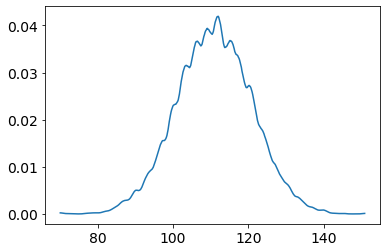

In [204]:
sim = posterior_prediction_simulation(200, samples)
_, ax = plt.subplots()
az.plot_kde(sim.numpy());
# fits the data well

3H4. Now compare 10,000 counts of boys from 100 simulated first borns only to the number of boys
in the first births, birth1 . How does the model look in this light?

In [205]:
print("{:d} out of 100 first borns are boys".format(np.sum(birth1)))

51 out of 100 first borns are boys


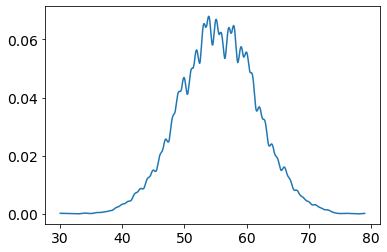

In [206]:
sim = posterior_prediction_simulation(100, samples)
_, ax = plt.subplots()
az.plot_kde(sim.numpy());
# simulations from the posterior for all male births don't fit first born data that well

3H5. The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns. Compare 10,000 simulated counts
of boys to only those second births that followed girls. To do this correctly, you need to count the
number of first borns who were girls and simulate that many births, 10,000 times. Compare the
counts of boys in your simulations to the actual observed count of boys following girls. How does the
model look in this light? Any guesses what is going on in these data?

In [207]:
female_first_bool = tf.math.logical_not(tf.cast(birth1, dtype=tf.bool))
num_first_born_girls = tf.size(birth1) - tf.reduce_sum(birth1)
num_second_born_boys_after_first_born_girl = tf.reduce_sum(birth2[female_first_bool])
print("There were {:d} first born girls.\nWhen we consider these parents' second births, {:d} were boys and {:d} were girls".format(num_first_born_girls, num_second_born_boys_after_first_born_girl, num_first_born_girls - num_second_born_boys_after_first_born_girl))

There were 49 first born girls.
When we consider these parents' second births, 39 were boys and 10 were girls


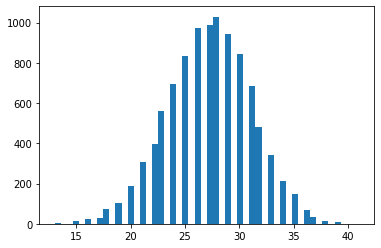

In [208]:
sim = posterior_prediction_simulation(49, samples)
sim = tf.cast(sim, dtype=tf.int32)
_, ax = plt.subplots()
ax.hist(sim[0,:].numpy(), bins=50);

In [209]:
# The model clearly doesn't look good in this light.
# It's a very small sample size, so one should be careful about jumping to conclusions.
# One possible explanation, however, is that many parents might desire a mix of genders/sexes.
# If this is the case, then many parents might stop at 2 kids if and only if they get 1 boy and 1 girl
# In this example, if these couples got a second girl then they might keep trying, in which case they 
# are no longer part of the dataset (the key is that this dataset includes families that have exactly 2 kids)

# we could quickly test this by making sure that the opposite case also shows a bias
# (e.g. to discount an alternative theory that parents keep trying until they have a boy, which means some
# potential 2 kid families might stop at a single boy)
# (i.e. we predict that for first born boys there shoudl be a bias towards second born girls)

male_first_bool = tf.cast(birth1, dtype=tf.bool)
num_first_born_boys = tf.reduce_sum(birth1)
num_second_born_girls_after_first_born_boy = num_first_born_boys - tf.reduce_sum(birth2[male_first_bool])
print("There were {:d} first born boys.\nWhen we consider these parents' second births, {:d} were girls and {:d} were boys".format(num_first_born_boys, num_second_born_girls_after_first_born_boy, num_first_born_boys - num_second_born_girls_after_first_born_boy))

There were 51 first born boys.
When we consider these parents' second births, 30 were girls and 21 were boys


In [210]:
# as predicted there is a bias